In [176]:
from builtins import sorted
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
import os
import sys
import shutil
import pandas as pd
from tabulate import tabulate
import mir_eval

from scipy import signal, ndimage
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec
import IPython.display as ipd

from scipy.signal import argrelmax
import textwrap
from midi2audio import FluidSynth

# use a custom sound font
FluidSynth('default_sound_font.sf2')

# use a custom sample rate
FluidSynth(sample_rate=22050)

In [177]:
def sort_key_num(name_file:str, str_key=str.lower, nzero:int=5) -> str:
    return str_key( re.sub("(.[0-9]+)",lambda x: x.group(0).zfill(nzero),name_file) )

In [178]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [179]:
def get_estimate_tempo(frequency_scale, tempogram, scale):
    tempo_vector = np.sum(tempogram, axis=1)
    peak_index = argrelmax(tempo_vector)
    # 找相對最大值 => 峰值
    # x = np.array([2, 1, 2, 3, 2, 0, 1, 0])
    # argrelmax(x)
    # output:(array([3, 6]),)
    # print(peak_index)
    zip_find_peak = zip(tempo_vector[peak_index], frequency_scale[peak_index])
    # print(list(zip_peak))
    peaks = sorted(zip_find_peak, key=lambda x: x[0], reverse=True) #大到小排序
    # print(peaks)
    tempos = peaks[:2]
    # print(tempos)
    if tempos[0][1] > tempos[1][1]: #取出的前兩大峰值之 frequency 以小到大排序
        tempos = tempos[::-1]
    # print(tempos)
    # 顯著性(saliency) 𝑆1 = 𝐹(𝑇1, 𝑛)/(𝐹(𝑇1, 𝑛) + 𝐹(𝑇2, 𝑛)) for tempo value 𝑡 at a specific time at 𝑛
    s1 = tempos[0][0] / (tempos[0][0] + tempos[1][0])
    return [scale * tempos[0][1], scale * tempos[1][1]], s1

In [180]:
# 𝑃 score = 𝑆1 * 𝑇_𝑡1 + (1 − 𝑆1) * 𝑇_𝑡2
def get_p_score(big_t, s1):
    return (s1 * big_t[0]) + ((1 - s1) * big_t[1])

In [181]:
def get_alotc_score(likely_tempos, ground_truth):
    alotc_score = 0
    if abs((ground_truth - likely_tempos[0])/ground_truth) < 0.08 or abs((ground_truth - likely_tempos[0])/ground_truth) == 0.08:
        alotc_score = 1
    elif abs((ground_truth - likely_tempos[1])/ground_truth) < 0.08 or abs((ground_truth - likely_tempos[1])/ground_truth) == 0.08:
        alotc_score = 1
    else:
        alotc_score = 0
    return alotc_score

In [182]:
genres_list = ["ChaCha", "Jive", "Quickstep", "Rumba", "Samba", "Tango", "Viennese waltz", "Waltz"]
tempogram_list = ["fourier", "autocorrelation"]

In [183]:
album_list = ["Abba", "Alan_Parsons_Project", "Alirio Diaz", "aphex_twin", "Asian_Dub_Foundation", "Autechre",
              "Aviador_Dro", "Bach", "Bach - Walcha", "Bebel_Gilberto", "Bela_Bartok", "Bernstein_conducts_Stravinsky",
              "Billie Holiday CD1", "Bjork", "Cabaret_Voltaire", "Carlinhos_Brown", "charles_mingus", "Classic",
              "Elton Medeiros, Nelson Sargento & Galo Preto", "Fado", "Femi_Kuti", "Genesis", "greek", "GUITARE+",
              "john_coltrane", "John Frusciante", "Jose' Merce'", "Kocani Orkester", "Manu_Chao", "more greek",
              "Nina Pastori", "Olivier Chassain", "Papakonstantinou", "Paulinho da Viola & Elton Medeiros", "Santana",
              "Songs", "Teresa Cristina", "Tomatito", "Vangelis", "Xatzidakis"]

## Ballroom

In [203]:
def get_beat_tracking_ballroom(visualization):
    # path = "./HW2 Datasets/Ballroom/"
    wav_path = "./HW2 Datasets/Ballroom/BallroomData/"
    ground_truth_path = "./HW2 Datasets/Ballroom/BallroomAnnotations-master/"
    f_score_dict = {}
    for genre in genres_list:
        f_score_dict[genre] = {}
        for root, dirs, files in os.walk(os.path.join(wav_path, genre)):
            files = sorted(files, key=sort_key_num)
            # print(files)
            song_no = 0
            for name in files:
                if name.endswith((".wav")):
                    f_score_dict[genre][song_no] = {}
                    # tempo, beat_times = librosa.beat.beat_track(x, sr=sr, start_bpm=60, units='time')
                    audio_file_path = wav_path + genre + "/" + name
                    # print("audio_file_path: ", audio_file_path)
                    bpm_name = name.replace(".wav", ".beats")

                    sr = 22050
                    audio, sr = librosa.load(audio_file_path, sr = sr)
                    
                    tempo, beat_times = librosa.beat.beat_track(y = audio, sr = sr)#  start_bpm = 60, units = 'time'
                    estimate_beats = librosa.frames_to_time(beat_times, sr = sr)
                    # print(tempo)
                    # print(beat_times)
                    
                    if visualization == 1:
                        plt.figure(figsize=(14, 5))
                        librosa.display.waveshow(audio, alpha=0.6)
                        plt.vlines(beat_times, -1, 1, color='r')
                        plt.ylim(-1, 1)
                        plt.show()
                        
                        beat_times_diff = np.diff(beat_times)
                        plt.figure(figsize=(14, 5))
                        plt.hist(beat_times_diff, bins=50, range=(0,4))
                        plt.xlabel('Beat Length (seconds)')
                        plt.ylabel('Count')
                        plt.show()

                    ground_truth_beats, _ = mir_eval.io.load_labeled_events(os.path.join(ground_truth_path, bpm_name))
                    #print(ground_truth_beats)
                    ground_truth_beats = mir_eval.beat.trim_beats(ground_truth_beats)
                    #located within a tolerance of ±70 ms around the ground truth annotation, 70ms = 0.007sec
                    # f_score = mir_eval.beat.f_measure(ground_truth_beats, beat_times, f_measure_threshold = 0.07)
                    f_score = mir_eval.beat.f_measure(ground_truth_beats, estimate_beats, f_measure_threshold = 0.07)
                    
                    # print('f_score:', f_score)
                    f_score_dict[genre][song_no]["f_score"] = f_score
                    song_no += 1
    return f_score_dict

In [204]:
f_score_dict_ballroom = get_beat_tracking_ballroom(0)
f_score_dict_ballroom

{'ChaCha': {0: {'f_score': 0.9043478260869565},
  1: {'f_score': 0.890909090909091},
  2: {'f_score': 0.8928571428571428},
  3: {'f_score': 0.8928571428571428},
  4: {'f_score': 0.8571428571428571},
  5: {'f_score': 0.9026548672566371},
  6: {'f_score': 0.8928571428571429},
  7: {'f_score': 0.911764705882353},
  8: {'f_score': 0.9009009009009009},
  9: {'f_score': 0.8712871287128713},
  10: {'f_score': 0.8965517241379309},
  11: {'f_score': 0.8571428571428572},
  12: {'f_score': 0.9043478260869565},
  13: {'f_score': 0.8928571428571428},
  14: {'f_score': 0.6428571428571429},
  15: {'f_score': 0.8928571428571428},
  16: {'f_score': 0.8928571428571428},
  17: {'f_score': 0.8869565217391304},
  18: {'f_score': 0.12068965517241378},
  19: {'f_score': 0.8928571428571429},
  20: {'f_score': 0.8928571428571428},
  21: {'f_score': 0.8623853211009175},
  22: {'f_score': 0.8113207547169811},
  23: {'f_score': 0.8965517241379309},
  24: {'f_score': 0.8990825688073394},
  25: {'f_score': 0.896551

    composer  song_no   f_score
0     ChaCha        0  0.904348
1     ChaCha        1  0.890909
2     ChaCha        2  0.892857
3     ChaCha        3  0.892857
4     ChaCha        4  0.857143
..       ...      ...       ...
693    Waltz      105  0.448276
694    Waltz      106  0.794872
695    Waltz      107  0.553571
696    Waltz      108  0.876712
697    Waltz      109  0.320000

[698 rows x 3 columns]


/tmp/ipykernel_1786277/2183915324.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  result_ballroom = ballroom_score_dict_df.drop(columns=['song_no']).mean()


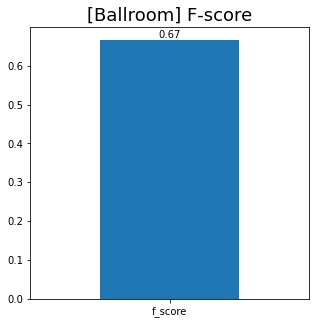

In [205]:
columns = ['composer', 'song_no', 'f_score']
ballroom_score_dict_df = pd.DataFrame.from_dict({(i, j): f_score_dict_ballroom[i][j]
                            for i in f_score_dict_ballroom.keys()
                            for j in f_score_dict_ballroom[i].keys()
                            }, orient='columns').T

ballroom_score_dict_df.reset_index(inplace=True)
ballroom_score_dict_df.columns = ['composer', 'song_no', 'f_score']
print(ballroom_score_dict_df)
result_ballroom = ballroom_score_dict_df.drop(columns=['song_no']).mean()

ax = result_ballroom.plot(kind='bar', figsize=(5, 5), rot=0)
ax.set_title("[Ballroom] F-score", fontsize=18)
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', )

## On ASAP, SMC, JCS

In [213]:
def get_beat_tracking_SMC(visualization):
    wav_path = "./HW2 Datasets/SMC_MIREX/SMC_MIREX_Audio/"
    ground_truth_path = "./HW2 Datasets/SMC_MIREX/SMC_MIREX_Annotations_05_08_2014/"
    f_score_dict = {}
    # print(wav_path)
    
    gt_files = []
    for root, dirs, files in os.walk(os.path.join(ground_truth_path)):
        gt_files = sorted(files, key=sort_key_num)
        # print(gt_files)
    for root, dirs, files in os.walk(os.path.join(wav_path)):
        files = sorted(files, key=sort_key_num)
        # print(files)
        song_no = 0
        for name in files:
            if name.endswith((".wav")):
                f_score_dict[song_no] = {}
                # tempo, beat_times = librosa.beat.beat_track(x, sr=sr, start_bpm=60, units='time')
                audio_file_path = wav_path + name
                # print("audio_file_path: ", audio_file_path)
                bpm_name =  [s for s in gt_files if any(xs in s for xs in name)]#name.replace(".wav", ".txt")
                # print(bpm_name)
                bpm_name = bpm_name[song_no]

                sr = 22050
                audio, sr = librosa.load(audio_file_path, sr = sr)
                
                #tempo, beat_times = librosa.beat.beat_track(y = audio, sr = sr, start_bpm = 60, units = 'time')
                tempo, beat_times = librosa.beat.beat_track(y = audio, sr = sr)#  start_bpm = 60, units = 'time'
                estimate_beats = librosa.frames_to_time(beat_times, sr = sr)
                # estimate_beats = librosa.frames_to_time(beat_times, sr = sr)
                # print(tempo)
                # print(beat_times)
                
                if visualization == 1:
                    plt.figure(figsize=(14, 5))
                    librosa.display.waveshow(audio, alpha=0.6)
                    plt.vlines(beat_times, -1, 1, color='r')
                    plt.ylim(-1, 1)
                    plt.show()
                    
                    beat_times_diff = np.diff(beat_times)
                    plt.figure(figsize=(14, 5))
                    plt.hist(beat_times_diff, bins=50, range=(0,4))
                    plt.xlabel('Beat Length (seconds)')
                    plt.ylabel('Count')
                    plt.show()

                ground_truth_beats = []
                gt_file_path = os.path.join(ground_truth_path, bpm_name)
                ground_truth_beats = mir_eval.io.load_events(gt_file_path)
                # with open(gt_file_path) as f:
                #     for line in f.readlines():
                #         # print(line)
                #         ground_truth_beats.append(float(line))
                # print(ground_truth_beats)
                
                ground_truth_beats = mir_eval.beat.trim_beats(ground_truth_beats)
                
                #located within a tolerance of ±70 ms around the ground truth annotation, 70ms = 0.007sec
                f_score = mir_eval.beat.f_measure(ground_truth_beats, estimate_beats, f_measure_threshold = 0.07)
                
                # print('f_score:', f_score)
                f_score_dict[song_no]["f_score"] = f_score
                song_no += 1
    return f_score_dict

In [214]:
smc_f_score_dict = get_beat_tracking_SMC(0)

In [215]:
smc_f_score_dict

{0: {'f_score': 0.5084745762711865},
 1: {'f_score': 0.208955223880597},
 2: {'f_score': 0.33587786259541985},
 3: {'f_score': 0.3125},
 4: {'f_score': 0.19607843137254904},
 5: {'f_score': 0.3622047244094488},
 6: {'f_score': 0.1782178217821782},
 7: {'f_score': 0.5061728395061728},
 8: {'f_score': 0.34965034965034963},
 9: {'f_score': 0.2068965517241379},
 10: {'f_score': 0.43575418994413406},
 11: {'f_score': 0.24277456647398843},
 12: {'f_score': 0.6194690265486725},
 13: {'f_score': 0.6138613861386139},
 14: {'f_score': 0.2258064516129032},
 15: {'f_score': 0.2312925170068027},
 16: {'f_score': 0.2429906542056075},
 17: {'f_score': 0.3803680981595092},
 18: {'f_score': 0.3421052631578947},
 19: {'f_score': 0.16923076923076924},
 20: {'f_score': 0.32558139534883723},
 21: {'f_score': 0.21428571428571427},
 22: {'f_score': 0.6956521739130435},
 23: {'f_score': 0.24000000000000002},
 24: {'f_score': 0.18556701030927836},
 25: {'f_score': 0.5248226950354611},
 26: {'f_score': 0.338983

In [216]:
columns = ['song_no', 'f_score']
smc_score_dict_df = pd.DataFrame.from_dict({(i): smc_f_score_dict[i]
                            for i in smc_f_score_dict.keys()
                            }, orient='columns').T

smc_score_dict_df.reset_index(inplace=True)
smc_score_dict_df.columns = ['song_no', 'f_score']

In [217]:
smc_score_dict_df

,song_no,f_score
0,0,0.508475
1,1,0.208955
2,2,0.335878
3,3,0.312500
4,4,0.196078
...,...,...
212,212,0.322581
213,213,0.907407
214,214,0.787402
215,215,0.790323


In [218]:
result_smc = smc_score_dict_df.drop(columns=['song_no']).mean()
result_smc

f_score    0.313371
dtype: float64

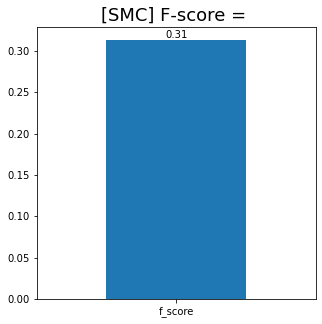

In [219]:
ax = result_smc.plot(kind='bar', figsize=(5, 5), rot=0)
ax.set_title("[SMC] F-score = ", fontsize=18)
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', )

## =========================================================

In [210]:
def get_beat_tracking_JCS(visualization):
    wav_path = "./HW2 Datasets/JCS_dataset/audio/"
    ground_truth_path = "./HW2 Datasets/JCS_dataset/annotations/"
    f_score_dict = {}
    # print(wav_path)
    
    gt_files = []
    for root, dirs, files in os.walk(os.path.join(ground_truth_path)):
        gt_files = sorted(files, key=sort_key_num)
        # print(gt_files)
    for root, dirs, files in os.walk(os.path.join(wav_path)):
        files = sorted(files, key=sort_key_num)
        # print(files)
        song_no = 0
        for name in files:
            if name.endswith((".mp3")):
                f_score_dict[song_no] = {}
                # tempo, beat_times = librosa.beat.beat_track(x, sr=sr, start_bpm=60, units='time')
                audio_file_path = wav_path + name
                # print("audio_file_path: ", audio_file_path)
                bpm_name =  [s for s in gt_files if any(xs in s for xs in name)]#name.replace(".wav", ".txt")
                # print(bpm_name)
                bpm_name = bpm_name[song_no]

                sr = 22050
                audio, sr = librosa.load(audio_file_path, sr = sr)
                
                #tempo, beat_times = librosa.beat.beat_track(y = audio, sr = sr, start_bpm = 60, units = 'time')
                tempo, beat_times = librosa.beat.beat_track(y = audio, sr = sr)#  start_bpm = 60, units = 'time'
                estimate_beats = librosa.frames_to_time(beat_times, sr = sr)
                # estimate_beats = librosa.frames_to_time(beat_times, sr = sr)
                # print(tempo)
                # print(beat_times)
                
                if visualization == 1:
                    plt.figure(figsize=(14, 5))
                    librosa.display.waveshow(audio, alpha=0.6)
                    plt.vlines(beat_times, -1, 1, color='r')
                    plt.ylim(-1, 1)
                    plt.show()
                    
                    beat_times_diff = np.diff(beat_times)
                    plt.figure(figsize=(14, 5))
                    plt.hist(beat_times_diff, bins=50, range=(0,4))
                    plt.xlabel('Beat Length (seconds)')
                    plt.ylabel('Count')
                    plt.show()

                ground_truth_beats = []
                gt_file_path = os.path.join(ground_truth_path, bpm_name)
                ground_truth_beats, _ = mir_eval.io.load_labeled_events(os.path.join(ground_truth_path, bpm_name))
                # with open(gt_file_path) as f:
                #     for line in f.readlines():
                #         # print(line)
                #         ground_truth_beats.append(float(line))
                # print(ground_truth_beats)
                ground_truth_beats = mir_eval.beat.trim_beats(ground_truth_beats)
                
                #located within a tolerance of ±70 ms around the ground truth annotation, 70ms = 0.007sec
                f_score = mir_eval.beat.f_measure(ground_truth_beats, estimate_beats, f_measure_threshold = 0.07)
                
                # print('f_score:', f_score)
                f_score_dict[song_no]["f_score"] = f_score
                song_no += 1
    return f_score_dict

In [211]:
jcs_f_score_dict = get_beat_tracking_JCS(0)
jcs_f_score_dict

/home/ilc/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/ilc/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/ilc/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/ilc/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/ilc/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/ilc/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/hom

{0: {'f_score': 0.4937142857142857},
 1: {'f_score': 0.9207547169811321},
 2: {'f_score': 0.9414270500532481},
 3: {'f_score': 0.9807208717518859},
 4: {'f_score': 0.7139423076923077},
 5: {'f_score': 0.8806941431670282},
 6: {'f_score': 0.9261939218523877},
 7: {'f_score': 0.39285714285714285},
 8: {'f_score': 0.5},
 9: {'f_score': 0.5642276422764227},
 10: {'f_score': 0.5888456549935149},
 11: {'f_score': 0.5040071237756011},
 12: {'f_score': 0.4610639938319198},
 13: {'f_score': 0.5900900900900901},
 14: {'f_score': 0.5231607629427792},
 15: {'f_score': 0.7259786476868327},
 16: {'f_score': 0.8045454545454547},
 17: {'f_score': 0.304635761589404},
 18: {'f_score': 0.8022284122562674},
 19: {'f_score': 0.505859375},
 20: {'f_score': 0.4907348242811502},
 21: {'f_score': 0.9392624728850325},
 22: {'f_score': 0.24242424242424243}}

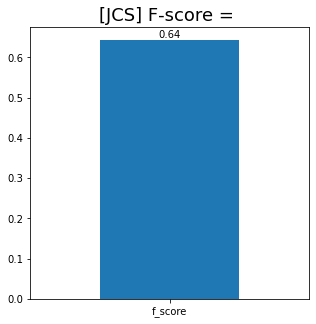

In [212]:
columns = ['song_no', 'f_score']
jcs_score_dict_df = pd.DataFrame.from_dict({(i): jcs_f_score_dict[i]
                            for i in jcs_f_score_dict.keys()
                            }, orient='columns').T

jcs_score_dict_df.reset_index(inplace=True)
jcs_score_dict_df.columns = ['song_no', 'f_score']

result_jcs = jcs_score_dict_df.drop(columns=['song_no']).mean()

ax = result_jcs.plot(kind='bar', figsize=(5, 5), rot=0)
ax.set_title("[JCS] F-score = ", fontsize=18)
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', )

## ASAP

In [194]:
composer_list = ['Brahms', 'Debussy', 'Glinka', 'Liszt', 'Prokofiev']

### Generate WAV file
有兩個作曲家目錄下的 wav 檔有缺失，因此利用 python 中 midi2audio 套件來產生 wav 檔案。

In [195]:
turn_to_audio_list = ['Prokofiev', 'Brahms']
fs = FluidSynth('musescore_default_sound_font.sf2')
#FluidSynth('sound_font.sf2')
for turn_to_audio in turn_to_audio_list:
    midi_path = "./HW2 Datasets/ASAP/"
    for root, dirs, files in os.walk(midi_path + turn_to_audio + "/mid/"):
        files = sorted(files, key=sort_key_num)
        for name in files:
            audio_file_path = midi_path + turn_to_audio + "/mid/" + name
            if name.endswith((".mid")):
                out_name = name.replace(".mid", ".wav")
                newpath = midi_path + turn_to_audio + "/wav/"
                if not os.path.exists(newpath):
                    os.makedirs(newpath)
                out_path = midi_path + turn_to_audio + "/wav/" + out_name
                print(audio_file_path)
                fs.midi_to_audio(audio_file_path, out_path)
                #Prokofiev, Brahms

./HW2 Datasets/ASAP/Prokofiev/mid/Colafelice11.mid


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: warning: Instrument not found on channel 0 [bank=108 prog=0], substituted [bank=0 prog=0]
fluidsynth: warning: Instrument not found on channel 1 [bank=108 prog=0], substituted [bank=0 prog=0]


FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file './HW2 Datasets/ASAP/Prokofiev/wav/Colafelice11.wav'..
./HW2 Datasets/ASAP/Prokofiev/mid/Dossin07.mid


fluidsynth: panic: An error occurred while reading from stdin.


FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file './HW2 Datasets/ASAP/Prokofiev/wav/Dossin07.wav'..
./HW2 Datasets/ASAP/Prokofiev/mid/Fab13.mid


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: warning: Instrument not found on channel 0 [bank=108 prog=0], substituted [bank=0 prog=0]
fluidsynth: warning: Instrument not found on channel 1 [bank=108 prog=0], substituted [bank=0 prog=0]


FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file './HW2 Datasets/ASAP/Prokofiev/wav/Fab13.wav'..
./HW2 Datasets/ASAP/Prokofiev/mid/Guo04.mid


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: warning: Instrument not found on channel 0 [bank=108 prog=0], substituted [bank=0 prog=0]
fluidsynth: warning: Instrument not found on channel 1 [bank=108 prog=0], substituted [bank=0 prog=0]


FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file './HW2 Datasets/ASAP/Prokofiev/wav/Guo04.wav'..
./HW2 Datasets/ASAP/Prokofiev/mid/Kociuban16.mid


fluidsynth: panic: An error occurred while reading from stdin.


FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file './HW2 Datasets/ASAP/Prokofiev/wav/Kociuban16.wav'..
./HW2 Datasets/ASAP/Prokofiev/mid/Lin06.mid


fluidsynth: panic: An error occurred while reading from stdin.


FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file './HW2 Datasets/ASAP/Prokofiev/wav/Lin06.wav'..
./HW2 Datasets/ASAP/Prokofiev/mid/Song04.mid


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: warning: Instrument not found on channel 0 [bank=108 prog=0], substituted [bank=0 prog=0]
fluidsynth: warning: Instrument not found on channel 1 [bank=108 prog=0], substituted [bank=0 prog=0]


FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file './HW2 Datasets/ASAP/Prokofiev/wav/Song04.wav'..
./HW2 Datasets/ASAP/Prokofiev/mid/Teo05.mid


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: warning: Instrument not found on channel 0 [bank=108 prog=0], substituted [bank=0 prog=0]
fluidsynth: warning: Instrument not found on channel 1 [bank=108 prog=0], substituted [bank=0 prog=0]


FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file './HW2 Datasets/ASAP/Prokofiev/wav/Teo05.wav'..
./HW2 Datasets/ASAP/Brahms/mid/Shilyaev03.mid


fluidsynth: panic: An error occurred while reading from stdin.


FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file './HW2 Datasets/ASAP/Brahms/wav/Shilyaev03.wav'..


In [196]:
def get_beat_tracking_APSP(visualization):
    # path = "./HW2 Datasets/Ballroom/"
    wav_path = "./HW2 Datasets/ASAP/"
    ground_truth_path = "./HW2 Datasets/ASAP/"
    f_score_dict = {}
    for composer in composer_list:
        f_score_dict[composer] = {}
        for root, dirs, files in os.walk(os.path.join(wav_path, composer)):
            files = sorted(files, key=sort_key_num)
            # print(files)
            song_no = 0
            for name in files:
                if name.endswith((".wav")):
                    f_score_dict[composer][song_no] = {}
                    # tempo, beat_times = librosa.beat.beat_track(x, sr=sr, start_bpm=60, units='time')
                    audio_file_path = wav_path + composer + "/wav/" + name
                    # print("audio_file_path: ", audio_file_path)
                    bpm_name = name.replace(".wav", "_annotations.txt")

                    sr = 22050
                    audio, sr = librosa.load(audio_file_path, sr = sr)
                    
                    #tempo, beat_times = librosa.beat.beat_track(y = audio, sr = sr, start_bpm = 60, units = 'time')
                    tempo, beat_times = librosa.beat.beat_track(y = audio, sr = sr)#  start_bpm = 60, units = 'time'
                    estimate_beats = librosa.frames_to_time(beat_times, sr = sr)
                    
                    # estimate_beats = librosa.frames_to_time(beat_times, sr = sr)
                    # print(tempo)
                    # print(beat_times)
                    
                    if visualization == 1:
                        plt.figure(figsize=(14, 5))
                        librosa.display.waveshow(audio, alpha=0.6)
                        plt.vlines(beat_times, -1, 1, color='r')
                        plt.ylim(-1, 1)
                        plt.show()
                        
                        beat_times_diff = np.diff(beat_times)
                        plt.figure(figsize=(14, 5))
                        plt.hist(beat_times_diff, bins=50, range=(0,4))
                        plt.xlabel('Beat Length (seconds)')
                        plt.ylabel('Count')
                        plt.show()

                    ground_truth_beats, _ = mir_eval.io.load_labeled_events(os.path.join(ground_truth_path + composer + "/annotation/", bpm_name))
                    # print(ground_truth_beats)
                    ground_truth_beats = mir_eval.beat.trim_beats(ground_truth_beats)
                    #located within a tolerance of ±70 ms around the ground truth annotation, 70ms = 0.007sec
                    f_score = mir_eval.beat.f_measure(ground_truth_beats, estimate_beats, f_measure_threshold = 0.07)
                    
                    # print('f_score:', f_score)
                    f_score_dict[composer][song_no]["f_score"] = f_score
                    song_no += 1
    return f_score_dict

In [197]:
apsp_f_score_dict = get_beat_tracking_APSP(0)
apsp_f_score_dict

{'Brahms': {0: {'f_score': 0.3987391646966115}},
 'Debussy': {0: {'f_score': 0.3147286821705426},
  1: {'f_score': 0.7066541705716963},
  2: {'f_score': 0.3605150214592275}},
 'Glinka': {0: {'f_score': 0.3180873180873181},
  1: {'f_score': 0.2972651605231867}},
 'Liszt': {0: {'f_score': 0.414702154626109},
  1: {'f_score': 0.2804674457429049},
  2: {'f_score': 0.3861386138613861},
  3: {'f_score': 0.31347962382445144},
  4: {'f_score': 0.4273504273504274},
  5: {'f_score': 0.39955064594645195},
  6: {'f_score': 0.2707383773928897},
  7: {'f_score': 0.42241630276564773},
  8: {'f_score': 0.39782850779510026},
  9: {'f_score': 0.3755569700827499},
  10: {'f_score': 0.4189189189189189},
  11: {'f_score': 0.2795698924731183},
  12: {'f_score': 0.377150722642808},
  13: {'f_score': 0.4241645244215938},
  14: {'f_score': 0.3769063180827887},
  15: {'f_score': 0.3396464646464646},
  16: {'f_score': 0.38603531300160515},
  17: {'f_score': 0.3847583643122677},
  18: {'f_score': 0.28647214854111

     composer  song_no   f_score
0      Brahms        0  0.398739
1     Debussy        0  0.314729
2     Debussy        1  0.706654
3     Debussy        2  0.360515
4      Glinka        0  0.318087
..        ...      ...       ...
57  Prokofiev        3  0.740331
58  Prokofiev        4  0.877940
59  Prokofiev        5  0.611973
60  Prokofiev        6  0.666667
61  Prokofiev        7  0.646733

[62 rows x 3 columns]


/tmp/ipykernel_1786277/1082595177.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  result_asap = apsp_score_dict_df.drop(columns=['song_no']).mean()


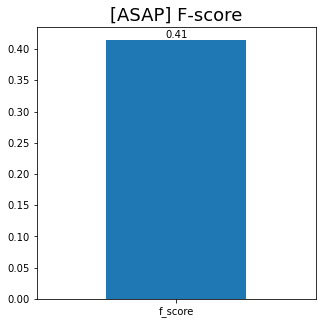

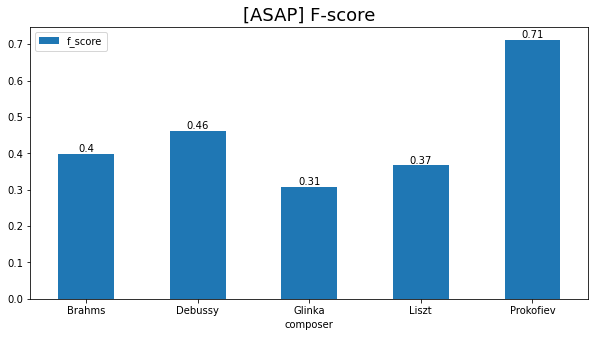

In [209]:
columns = ['composer', 'song_no', 'f_score']
apsp_score_dict_df = pd.DataFrame.from_dict({(i, j): apsp_f_score_dict[i][j]
                            for i in apsp_f_score_dict.keys()
                            for j in apsp_f_score_dict[i].keys()
                            }, orient='columns').T

apsp_score_dict_df.reset_index(inplace=True)
apsp_score_dict_df.columns = ['composer', 'song_no', 'f_score']
print(apsp_score_dict_df)
result_asap = apsp_score_dict_df.drop(columns=['song_no']).mean()
result_asap_composer = apsp_score_dict_df.drop(columns=['song_no']).groupby(['composer']).mean()


ax = result_asap.plot(kind='bar', figsize=(5, 5), rot=0)
ax.set_title("[ASAP] F-score", fontsize=18)
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', )
    
ax = result_asap_composer.plot(kind='bar', figsize=(10, 5), rot=0)
ax.set_title("[ASAP] F-score", fontsize=18)
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', )

In [220]:
concat_result = pd.concat([result_ballroom, result_jcs, result_smc, result_asap], axis=1)
concat_result.columns = ['Ballroom', 'JCS', 'SMC', 'APSP']
concat_result

,Ballroom,JCS,SMC,APSP
f_score,0.666133,0.643364,0.313371,0.41459


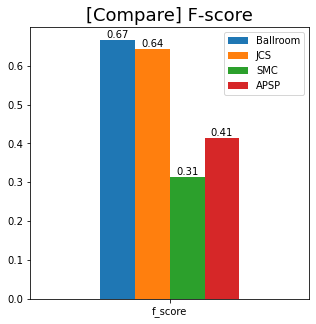

In [221]:
ax = concat_result.plot(kind='bar', figsize=(5, 5), rot=0)
ax.set_title("[Compare] F-score", fontsize=18)
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', )